In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, PredefinedSplit
from sklearn.feature_selection import r_regression, RFE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier, plot_tree, export_graphviz
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

In [2]:
clinical_file = '/kaggle/input/clinical-data/clinical-2.csv'
clinical = pd.read_csv(clinical_file)
del clinical['ID']
del clinical['SIDE']

In [3]:
clinical.head()

,FILENAME,AGE,HEIGHT,WEIGHT,MAX WEIGHT,BMI,FREQUENT PAIN,SURGERY,RISK,SXKOA,SWELLING,BENDING FULLY,SYMPTOMATIC,CREPITUS,KOOS PAIN SCORE
0,9000099L.png,59,1811.0,78.1,90.9,23.8,5: Freq pain both knees,1: Yes,5: Progression cohort,3: Both knees,0: Never,0: Always,1: Yes,1: Yes,100.0
1,9000296L.png,69,1682.0,84.3,84.1,29.8,0: No pain either knee,1: Yes,2: Incidence cohort: Risk factors only,0: Neither,0: Never,0: Always,0: No,0: No,100.0
2,9000622L.png,71,1587.5,57.2,62.3,22.7,"3: Freq pain 1 knee, no pain other knee",0: No,5: Progression cohort,1: Right knee only,0: Never,0: Always,0: No,0: No,100.0
3,9000798L.png,56,1788.5,103.6,123.6,32.4,"3: Freq pain 1 knee, no pain other knee",1: Yes,5: Progression cohort,2: Left knee only,4: Always,0: Always,1: Yes,1: Yes,59.4
4,9001104L.png,72,1589.5,77.6,77.3,30.7,"1: Infreq pain 1 knee, no pain other knee",0: No,3: Incidence cohort: Knee sx + risk factors,0: Neither,0: Never,0: Always,0: No,0: No,100.0


In [4]:
columns_to_scale = ['AGE', 'HEIGHT', 'WEIGHT', 'MAX WEIGHT', 'BMI', 'KOOS PAIN SCORE']
scaler = MinMaxScaler()

clinical[columns_to_scale] = scaler.fit_transform(clinical[columns_to_scale])
clinical

,FILENAME,AGE,HEIGHT,WEIGHT,MAX WEIGHT,BMI,FREQUENT PAIN,SURGERY,RISK,SXKOA,SWELLING,BENDING FULLY,SYMPTOMATIC,CREPITUS,KOOS PAIN SCORE
0,9000099L.png,0.411765,0.947427,0.388711,0.560158,0.216981,5: Freq pain both knees,1: Yes,5: Progression cohort,3: Both knees,0: Never,0: Always,1: Yes,1: Yes,1.000
1,9000296L.png,0.705882,0.874503,0.454739,0.493097,0.405660,0: No pain either knee,1: Yes,2: Incidence cohort: Risk factors only,0: Neither,0: Never,0: Always,0: No,0: No,1.000
2,9000622L.png,0.764706,0.821082,0.166134,0.278107,0.182390,"3: Freq pain 1 knee, no pain other knee",0: No,5: Progression cohort,1: Right knee only,0: Never,0: Always,0: No,0: No,1.000
3,9000798L.png,0.323529,0.934707,0.660277,0.882643,0.487421,"3: Freq pain 1 knee, no pain other knee",1: Yes,5: Progression cohort,2: Left knee only,4: Always,0: Always,1: Yes,1: Yes,0.594
4,9001104L.png,0.794118,0.822212,0.383387,0.426036,0.433962,"1: Infreq pain 1 knee, no pain other knee",0: No,3: Incidence cohort: Knee sx + risk factors,0: Neither,0: Never,0: Always,0: No,0: No,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9587,9999365R.png,0.323529,0.897397,0.513312,0.605523,0.421384,"4: Freq pain 1 knee, infreq pain other knee",0: No,3: Incidence cohort: Knee sx + risk factors,0: Neither,1: Rarely,0: Always,0: No,0: No,0.583
9588,9999510R.png,0.147059,0.979084,0.631523,0.681460,0.377358,"1: Infreq pain 1 knee, no pain other knee",1: Yes,3: Incidence cohort: Knee sx + risk factors,0: Neither,0: Never,0: Always,0: No,1: Yes,1.000
9589,9999862R.png,0.470588,0.849064,0.232162,0.318540,0.213836,2: Infreq pain both knees,0: No,2: Incidence cohort: Risk factors only,0: Neither,0: Never,0: Always,0: No,0: No,0.972
9590,9999865R.png,0.470588,0.811189,0.214058,0.290927,0.254717,0: No pain either knee,0: No,2: Incidence cohort: Risk factors only,0: Neither,0: Never,0: Always,0: No,1: Yes,1.000


In [5]:
columns_to_convert = ['FREQUENT PAIN', 'SURGERY', 'RISK', 'SXKOA', 'SWELLING', 'BENDING FULLY', 'SYMPTOMATIC', 'CREPITUS']
mapping_dict = {}

for column in columns_to_convert:
    clinical[column], unique_values = pd.factorize(clinical[column])
    mapping_dict[column] = unique_values

In [6]:
mapping_dict

{'FREQUENT PAIN': Index(['5: Freq pain both knees', '0: No pain either knee',
        '3: Freq pain 1 knee, no pain other knee',
        '1: Infreq pain 1 knee, no pain other knee',
        '4: Freq pain 1 knee, infreq pain other knee',
        '2: Infreq pain both knees', '.: Missing Form/Incomplete Workbook'],
       dtype='object'),
 'SURGERY': Index(['1: Yes', '0: No', '.: Missing Form/Incomplete Workbook'], dtype='object'),
 'RISK': Index(['5: Progression cohort', '2: Incidence cohort: Risk factors  only',
        '3: Incidence cohort: Knee sx + risk factors',
        '1: Incidence cohort: Knee symptoms only',
        '4: Incidence cohort: Protocol exception',
        '0: Non-eligible control cohort'],
       dtype='object'),
 'SXKOA': Index(['3: Both knees', '0: Neither', '1: Right knee only',
        '2: Left knee only', '.: Missing Form/Incomplete Workbook'],
       dtype='object'),
 'SWELLING': Index(['0: Never', '4: Always', '1: Rarely', '2: Sometimes', '3: Often',
        '.

In [7]:
train_dir = '/kaggle/input/xdesco-convnextb-outs/ConvNeXt/Fold 3/df_train.csv'
df_train = pd.read_csv(train_dir).dropna()

test_dir = '/kaggle/input/xdesco-convnextb-outs/ConvNeXt/Fold 3/df_test.csv'
df_test = pd.read_csv(test_dir).dropna()

val_dir = '/kaggle/input/xdesco-convnextb-outs/ConvNeXt/Fold 3/df_val.csv'
df_val = pd.read_csv(val_dir).dropna()

In [8]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          826 non-null    object 
 1   kl_grade          826 non-null    int64  
 2   subset            826 non-null    object 
 3   kl_grade_0        826 non-null    float64
 4   kl_grade_1        826 non-null    float64
 5   kl_grade_2        826 non-null    float64
 6   kl_grade_3        826 non-null    float64
 7   kl_grade_4        826 non-null    float64
 8   osteophytes_def   826 non-null    float64
 9   osteophytes_none  826 non-null    float64
 10  osteophytes_poss  826 non-null    float64
 11  jsn_def           826 non-null    float64
 12  jsn_mild/mod      826 non-null    float64
 13  jsn_none          826 non-null    float64
 14  jsn_severe        826 non-null    float64
 15  osfl_0            826 non-null    float64
 16  osfl_1            826 non-null    float64
 1

In [9]:
split = df_test
kl_grades = ['kl_grade_0', 'kl_grade_1', 'kl_grade_2', 'kl_grade_3', 'kl_grade_4']

nn_output = split[kl_grades].values
predicted_classes = np.argmax(nn_output, axis=1)
accuracy = np.mean(predicted_classes == split['kl_grade'])
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 72.10%


In [10]:
jsws = pd.read_csv('/kaggle/input/xdesco-jsws-info-2/jsws_2.csv')
del jsws["jsw_min"]
jsws

,id,subset,kl_grade,jsw_mean,jsw_mm
0,9095865R,train,2,0.290614,0.616180
1,9845238R,train,2,0.210993,0.690430
2,9060930L,train,2,0.246754,0.626806
3,9155763L,train,2,0.110046,0.313212
4,9861824L,train,2,0.353635,0.846892
...,...,...,...,...,...
8255,9841033R,test,4,0.551674,0.970780
8256,9282257R,test,4,0.657019,0.973895
8257,9101066R,test,4,0.419168,0.972028
8258,9495873R,test,4,0.676222,0.938551


In [11]:
df_train = df_train.merge(clinical, left_on='filename', right_on='FILENAME', how='left').drop(columns=['FILENAME']).dropna()
df_test = df_test.merge(clinical, left_on='filename', right_on='FILENAME', how='left').drop(columns=['FILENAME']).dropna()
df_val = df_val.merge(clinical, left_on='filename', right_on='FILENAME', how='left').drop(columns=['FILENAME']).dropna()

In [12]:
df_train['id'] = df_train.filename.str.slice(0, 8)
df_test['id'] = df_test.filename.str.slice(0, 8)
df_val['id'] = df_val.filename.str.slice(0, 8)
df_train = df_train.merge(jsws, on='id', how='left', suffixes=('', '_jsws')).drop(columns=['id', 'subset_jsws', 'kl_grade_jsws']).dropna()
df_test = df_test.merge(jsws, on='id', how='left', suffixes=('', '_jsws')).drop(columns=['id', 'subset_jsws', 'kl_grade_jsws']).dropna()
df_val = df_val.merge(jsws, on='id', how='left', suffixes=('', '_jsws')).drop(columns=['id', 'subset_jsws', 'kl_grade_jsws']).dropna()

In [13]:
df_train.columns

Index(['filename', 'kl_grade', 'subset', 'kl_grade_0', 'kl_grade_1',
       'kl_grade_2', 'kl_grade_3', 'kl_grade_4', 'osteophytes_def',
       'osteophytes_none', 'osteophytes_poss', 'jsn_def', 'jsn_mild/mod',
       'jsn_none', 'jsn_severe', 'osfl_0', 'osfl_1', 'osfl_2', 'osfl_3',
       'scfl_0', 'scfl_1', 'scfl_2', 'scfl_3', 'ostm_0', 'ostm_1', 'ostm_2',
       'ostm_3', 'sctm_0', 'sctm_1', 'sctm_2', 'sctm_3', 'osfm_0', 'osfm_1',
       'osfm_2', 'osfm_3', 'scfm_0', 'scfm_1', 'scfm_2', 'scfm_3', 'ostl_0',
       'ostl_1', 'ostl_2', 'ostl_3', 'sctl_0', 'sctl_1', 'sctl_2', 'sctl_3',
       'AGE', 'HEIGHT', 'WEIGHT', 'MAX WEIGHT', 'BMI', 'FREQUENT PAIN',
       'SURGERY', 'RISK', 'SXKOA', 'SWELLING', 'BENDING FULLY', 'SYMPTOMATIC',
       'CREPITUS', 'KOOS PAIN SCORE', 'jsw_mean', 'jsw_mm'],
      dtype='object')

In [14]:
X_train = df_train.iloc[:, 3:]
y_train = df_train['kl_grade']

X_val = df_val.iloc[:, 3:]
y_val = df_val['kl_grade']

X_test = df_test.iloc[:, 3:]
y_test = df_test['kl_grade']

X_train_np = df_train.iloc[:, 3:].to_numpy()
y_train_np = df_train['kl_grade'].to_numpy()

X_val_np = df_val.iloc[:, 3:].to_numpy()
y_val_np = df_val['kl_grade'].to_numpy()

X_test_np = df_test.iloc[:, 3:].to_numpy()
y_test_np = df_test['kl_grade'].to_numpy()

In [15]:
X_cv = pd.concat([df_train.iloc[:, 3:], df_val.iloc[:, 3:]])
y_cv = pd.concat([df_train.iloc[:, 1], df_val.iloc[:, 1]])

X_cv_np = X_cv.to_numpy()
y_cv_np = y_cv.to_numpy()

In [16]:
classifier = LogisticRegression(max_iter=1000)
rfe = RFE(classifier, n_features_to_select=30)
rfe = rfe.fit(X_cv, y_cv)

rfe_lg_filtered_list = X_cv.columns[rfe.support_].to_list()

In [17]:
classifier = SVC(kernel='linear')
rfe = RFE(classifier, n_features_to_select=30)
rfe = rfe.fit(X_cv, y_cv)

rfe_svc_filtered_list = X_cv.columns[rfe.support_].to_list()

In [18]:
pearson = []
for i in range(X_cv_np.shape[1]):
    corr, _ = pearsonr(X_cv_np[:, i], y_cv_np)
    pearson.append(corr)

top_30_indices = np.argpartition(np.abs(pearson), -30)[-30:]
pearson_filtered_list = X_cv.iloc[:, top_30_indices].columns.to_list()

In [19]:
alpha_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha_range)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

grid = GridSearchCV(Ridge(), param_grid, cv=kf, n_jobs=-1, verbose=3)
grid.fit(X_cv_np, y_cv_np)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             verbose=3)

In [20]:
ridge = Ridge(alpha=grid.best_params_['alpha'])
ridge.fit(X_cv_np, y_cv_np)
importances = ridge.coef_
feature_names = X_cv.columns
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by absolute value of importance
df_importances['abs_importance'] = df_importances['importance'].abs()
df_importances = df_importances.sort_values('abs_importance', ascending=False)
ridge_filtered_list = df_importances['feature'][:30].to_list()

In [21]:
alpha_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha_range)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

grid = GridSearchCV(Lasso(), param_grid, cv=kf, n_jobs=-1)
grid.fit(X_cv_np, y_cv_np)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [22]:
lasso = Lasso(alpha=grid.best_params_['alpha'])
lasso.fit(X_cv_np, y_cv_np)
importances = lasso.coef_
feature_names = X_cv.columns
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by absolute value of importance
df_importances['abs_importance'] = df_importances['importance'].abs()
df_importances = df_importances.sort_values('abs_importance', ascending=False)
lasso_filtered_list = df_importances[df_importances['abs_importance'] > 1e-6]['feature'].tolist()
# lasso_filtered_list = df_importances['feature'][:30].to_list()

In [23]:
from collections import Counter

filtered_dict = {
    'RFE + Logistic Regression': rfe_lg_filtered_list,
    'RFE + SVC': rfe_svc_filtered_list,
    'Pearson': pearson_filtered_list,
    'Ridge': ridge_filtered_list,
    'Lasso': lasso_filtered_list,
}

all_features = sum(filtered_dict.values(), [])
combined = [item for item, count in Counter(all_features).most_common(30)]
filtered_dict['Combined'] = combined

filtered_dict["All"] = X_cv.columns.tolist()
filtered_dict

{'RFE + Logistic Regression': ['kl_grade_0',
  'kl_grade_1',
  'kl_grade_2',
  'kl_grade_3',
  'kl_grade_4',
  'osteophytes_def',
  'osteophytes_none',
  'jsn_mild/mod',
  'jsn_none',
  'jsn_severe',
  'osfl_0',
  'scfl_0',
  'ostm_0',
  'ostm_1',
  'ostm_2',
  'sctm_0',
  'sctm_1',
  'sctm_2',
  'osfm_0',
  'osfm_3',
  'scfm_1',
  'ostl_0',
  'ostl_2',
  'ostl_3',
  'sctl_0',
  'sctl_2',
  'WEIGHT',
  'BMI',
  'jsw_mean',
  'jsw_mm'],
 'RFE + SVC': ['kl_grade_0',
  'kl_grade_1',
  'kl_grade_2',
  'kl_grade_3',
  'kl_grade_4',
  'osteophytes_def',
  'osteophytes_none',
  'osteophytes_poss',
  'jsn_mild/mod',
  'jsn_severe',
  'osfl_0',
  'osfl_1',
  'scfl_0',
  'scfl_2',
  'ostm_0',
  'ostm_1',
  'sctm_1',
  'sctm_2',
  'osfm_2',
  'scfm_0',
  'scfm_1',
  'scfm_2',
  'ostl_0',
  'ostl_1',
  'ostl_3',
  'sctl_2',
  'WEIGHT',
  'BMI',
  'jsw_mean',
  'jsw_mm'],
 'Pearson': ['kl_grade_4',
  'osfm_1',
  'ostm_3',
  'jsw_mm',
  'scfm_2',
  'scfm_1',
  'ostl_0',
  'ostl_1',
  'ostl_2',
  'sc

In [24]:
def custom_grid_search(estimator, param_dict, filtered_list, n_splits=3):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1024)
    gs = GridSearchCV(estimator, param_dict, cv=kf, n_jobs=-1)
    gs.fit(X_cv[filtered_list], y_cv)
    return gs.best_params_

In [25]:
def report(model, column_names):
    model.fit(X_train[column_names].to_numpy(), y_train_np)
    print("Train accuracy: {:.2f}%".format(model.score(X_train[column_names].to_numpy(), y_train_np)*100))
    print("Test accuracy: {:.2f}%".format(model.score(X_test[column_names].to_numpy(), y_test_np)*100))
    y_pred = model.predict(X_test[column_names].to_numpy())
    print(classification_report(y_test_np, y_pred, digits=4))
    cm = confusion_matrix(y_test_np, y_pred, labels=[0,1,2,3,4])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
    disp.plot(cmap='Blues')
    plt.show()

In [26]:
def search_all(estimator, param_dict, filtered_dict, n_splits=3):
  for key, val in filtered_dict.items():
    print("Report for columns from", key)
    best_params = custom_grid_search(estimator(random_state=1024),
    param_dict, val)
    print("Best params:", best_params)
    report(estimator(random_state=1024, **best_params), val)
    print('-'*60)

Report for columns from RFE + Logistic Regression
Best params: {'class_weight': None, 'max_depth': 4}
Train accuracy: 83.37%
Test accuracy: 71.01%
              precision    recall  f1-score   support

           0     0.7945    0.8529    0.8226       639
           1     0.3953    0.4527    0.4220       296
           2     0.7404    0.6443    0.6890       447
           3     0.8730    0.7399    0.8010       223
           4     0.8302    0.8627    0.8462        51

    accuracy                         0.7101      1656
   macro avg     0.7267    0.7105    0.7162      1656
weighted avg     0.7202    0.7101    0.7128      1656



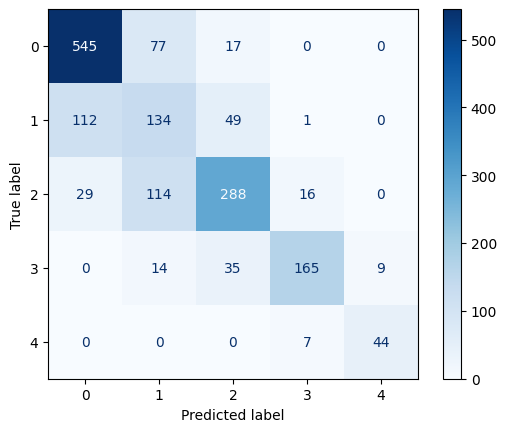

------------------------------------------------------------
Report for columns from RFE + SVC
Best params: {'class_weight': None, 'max_depth': 4}
Train accuracy: 83.37%
Test accuracy: 71.01%
              precision    recall  f1-score   support

           0     0.7945    0.8529    0.8226       639
           1     0.3953    0.4527    0.4220       296
           2     0.7404    0.6443    0.6890       447
           3     0.8730    0.7399    0.8010       223
           4     0.8302    0.8627    0.8462        51

    accuracy                         0.7101      1656
   macro avg     0.7267    0.7105    0.7162      1656
weighted avg     0.7202    0.7101    0.7128      1656



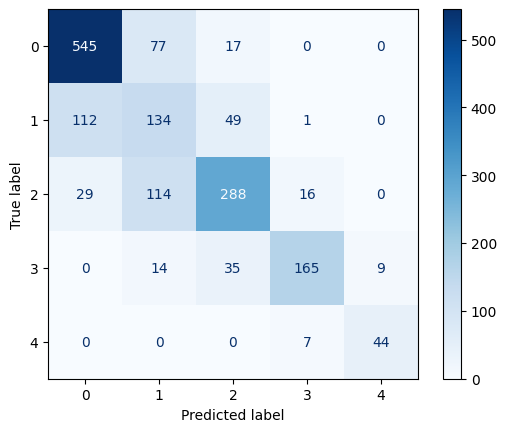

------------------------------------------------------------
Report for columns from Pearson
Best params: {'class_weight': None, 'max_depth': 4}
Train accuracy: 81.12%
Test accuracy: 70.65%
              precision    recall  f1-score   support

           0     0.7997    0.8435    0.8210       639
           1     0.3974    0.5169    0.4493       296
           2     0.7542    0.6040    0.6708       447
           3     0.8817    0.7354    0.8020       223
           4     0.8302    0.8627    0.8462        51

    accuracy                         0.7065      1656
   macro avg     0.7326    0.7125    0.7179      1656
weighted avg     0.7275    0.7065    0.7122      1656



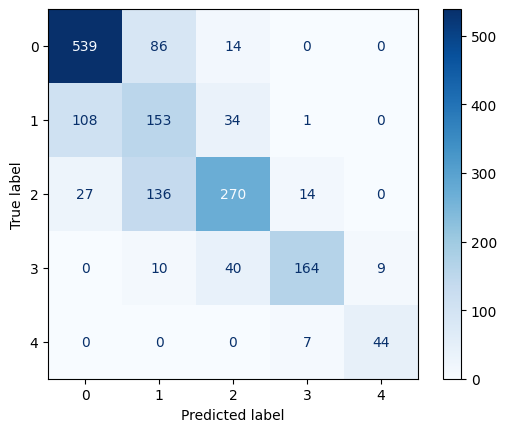

------------------------------------------------------------
Report for columns from Ridge
Best params: {'class_weight': None, 'max_depth': 4}
Train accuracy: 83.40%
Test accuracy: 71.20%
              precision    recall  f1-score   support

           0     0.7902    0.8607    0.8240       639
           1     0.3953    0.4527    0.4220       296
           2     0.7520    0.6376    0.6901       447
           3     0.8777    0.7399    0.8029       223
           4     0.8333    0.8824    0.8571        51

    accuracy                         0.7120      1656
   macro avg     0.7297    0.7147    0.7192      1656
weighted avg     0.7224    0.7120    0.7142      1656



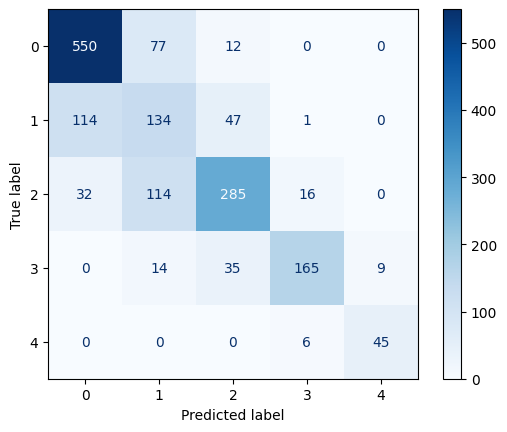

------------------------------------------------------------
Report for columns from Lasso
Best params: {'class_weight': None, 'max_depth': 4}
Train accuracy: 83.37%
Test accuracy: 70.95%
              precision    recall  f1-score   support

           0     0.7945    0.8529    0.8226       639
           1     0.3941    0.4527    0.4214       296
           2     0.7404    0.6443    0.6890       447
           3     0.8730    0.7399    0.8010       223
           4     0.8269    0.8431    0.8350        51

    accuracy                         0.7095      1656
   macro avg     0.7258    0.7066    0.7138      1656
weighted avg     0.7199    0.7095    0.7123      1656



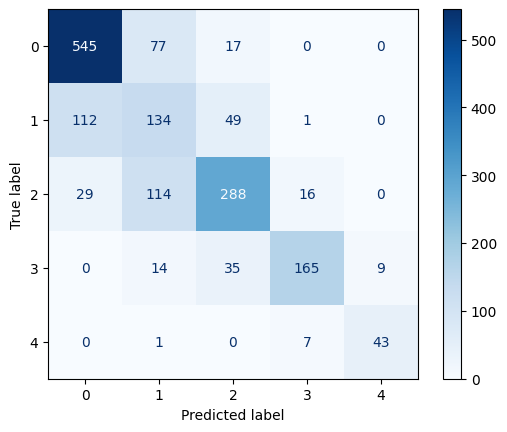

------------------------------------------------------------
Report for columns from Combined
Best params: {'class_weight': None, 'max_depth': 4}
Train accuracy: 83.37%
Test accuracy: 71.01%
              precision    recall  f1-score   support

           0     0.7945    0.8529    0.8226       639
           1     0.3953    0.4527    0.4220       296
           2     0.7404    0.6443    0.6890       447
           3     0.8730    0.7399    0.8010       223
           4     0.8302    0.8627    0.8462        51

    accuracy                         0.7101      1656
   macro avg     0.7267    0.7105    0.7162      1656
weighted avg     0.7202    0.7101    0.7128      1656



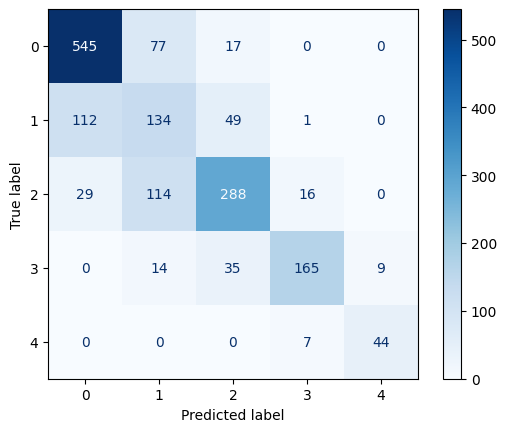

------------------------------------------------------------
Report for columns from All
Best params: {'class_weight': None, 'max_depth': 4}
Train accuracy: 83.42%
Test accuracy: 71.07%
              precision    recall  f1-score   support

           0     0.7945    0.8529    0.8226       639
           1     0.3953    0.4527    0.4220       296
           2     0.7404    0.6443    0.6890       447
           3     0.8777    0.7399    0.8029       223
           4     0.8333    0.8824    0.8571        51

    accuracy                         0.7107      1656
   macro avg     0.7282    0.7144    0.7187      1656
weighted avg     0.7209    0.7107    0.7134      1656



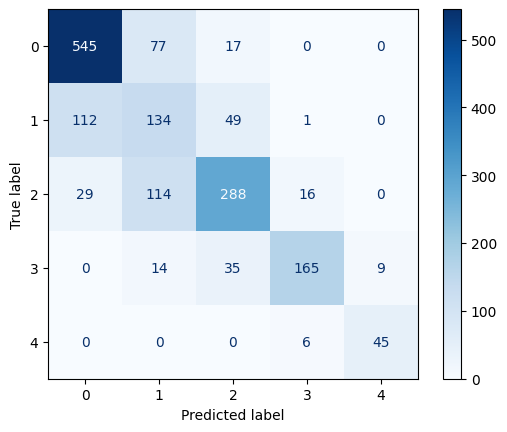

------------------------------------------------------------


In [27]:
search_all(
    DecisionTreeClassifier,
    {
        'max_depth': list(range(1, 30)),
        'class_weight': ['balanced', None]
    },
    filtered_dict
)

Report for columns from RFE + Logistic Regression
Best params: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Train accuracy: 85.50%
Test accuracy: 72.83%
              precision    recall  f1-score   support

           0     0.7903    0.8435    0.8160       639
           1     0.4227    0.4155    0.4191       296
           2     0.7454    0.7204    0.7327       447
           3     0.8812    0.7982    0.8376       223
           4     0.8980    0.8627    0.8800        51

    accuracy                         0.7283      1656
   macro avg     0.7475    0.7281    0.7371      1656
weighted avg     0.7280    0.7283    0.7275      1656



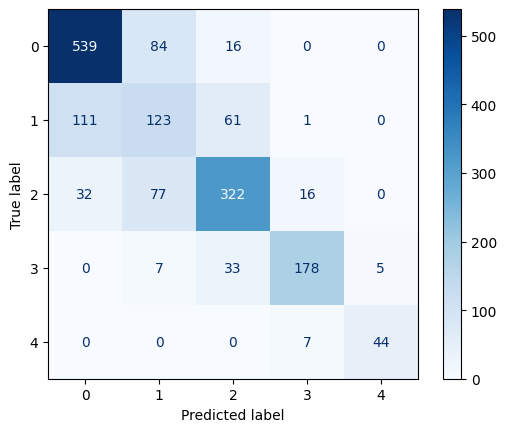

------------------------------------------------------------
Report for columns from RFE + SVC
Best params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Train accuracy: 84.84%
Test accuracy: 72.95%
              precision    recall  f1-score   support

           0     0.7964    0.8388    0.8171       639
           1     0.4314    0.4358    0.4336       296
           2     0.7500    0.7248    0.7372       447
           3     0.8676    0.7937    0.8290       223
           4     0.8750    0.8235    0.8485        51

    accuracy                         0.7295      1656
   macro avg     0.7441    0.7233    0.7331      1656
weighted avg     0.7307    0.7295    0.7296      1656



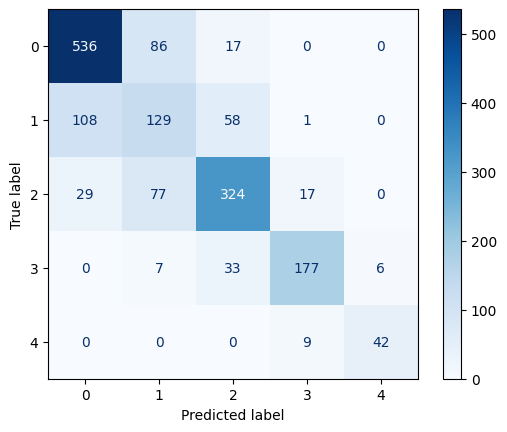

------------------------------------------------------------
Report for columns from Pearson
Best params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Train accuracy: 82.21%
Test accuracy: 71.62%
              precision    recall  f1-score   support

           0     0.8051    0.8341    0.8194       639
           1     0.3994    0.4426    0.4199       296
           2     0.7367    0.6823    0.7085       447
           3     0.8663    0.7848    0.8235       223
           4     0.8400    0.8235    0.8317        51

    accuracy                         0.7162      1656
   macro avg     0.7295    0.7135    0.7206      1656
weighted avg     0.7235    0.7162    0.7190      1656



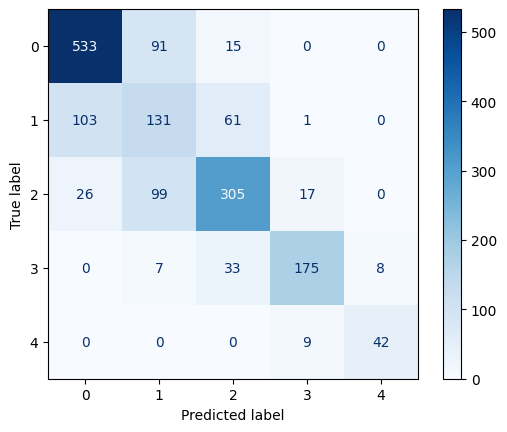

------------------------------------------------------------
Report for columns from Ridge
Best params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Train accuracy: 84.54%
Test accuracy: 72.52%
              precision    recall  f1-score   support

           0     0.7967    0.8404    0.8180       639
           1     0.4195    0.4223    0.4209       296
           2     0.7436    0.7204    0.7318       447
           3     0.8706    0.7848    0.8255       223
           4     0.8400    0.8235    0.8317        51

    accuracy                         0.7252      1656
   macro avg     0.7341    0.7183    0.7256      1656
weighted avg     0.7263    0.7252    0.7252      1656



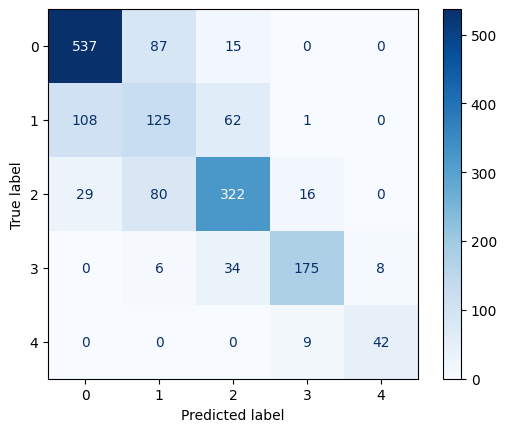

------------------------------------------------------------
Report for columns from Lasso
Best params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Train accuracy: 85.83%
Test accuracy: 72.40%
              precision    recall  f1-score   support

           0     0.7872    0.8451    0.8151       639
           1     0.4369    0.4324    0.4346       296
           2     0.7440    0.6957    0.7191       447
           3     0.8429    0.7937    0.8176       223
           4     0.8776    0.8431    0.8600        51

    accuracy                         0.7240      1656
   macro avg     0.7377    0.7220    0.7293      1656
weighted avg     0.7232    0.7240    0.7229      1656



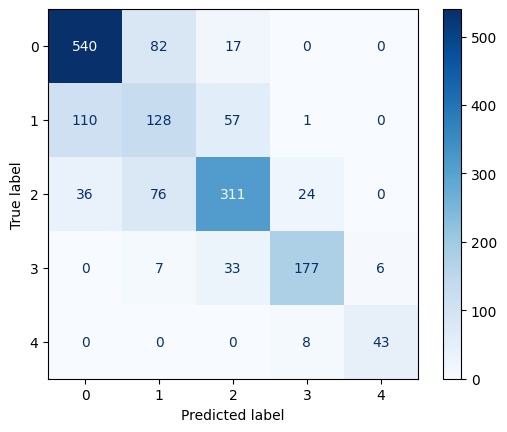

------------------------------------------------------------
Report for columns from Combined
Best params: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Train accuracy: 85.57%
Test accuracy: 72.52%
              precision    recall  f1-score   support

           0     0.7847    0.8498    0.8159       639
           1     0.4281    0.4020    0.4146       296
           2     0.7396    0.7181    0.7287       447
           3     0.8627    0.7892    0.8244       223
           4     0.8750    0.8235    0.8485        51

    accuracy                         0.7252      1656
   macro avg     0.7380    0.7165    0.7264      1656
weighted avg     0.7221    0.7252    0.7228      1656



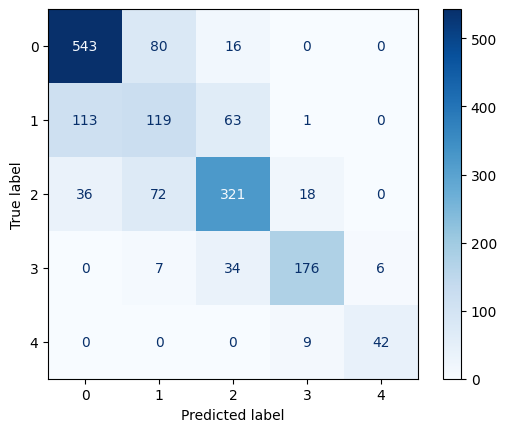

------------------------------------------------------------
Report for columns from All
Best params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Train accuracy: 85.74%
Test accuracy: 72.64%
              precision    recall  f1-score   support

           0     0.7949    0.8372    0.8155       639
           1     0.4351    0.4527    0.4437       296
           2     0.7452    0.7002    0.7220       447
           3     0.8634    0.7937    0.8271       223
           4     0.8800    0.8627    0.8713        51

    accuracy                         0.7264      1656
   macro avg     0.7437    0.7293    0.7359      1656
weighted avg     0.7290    0.7264    0.7271      1656



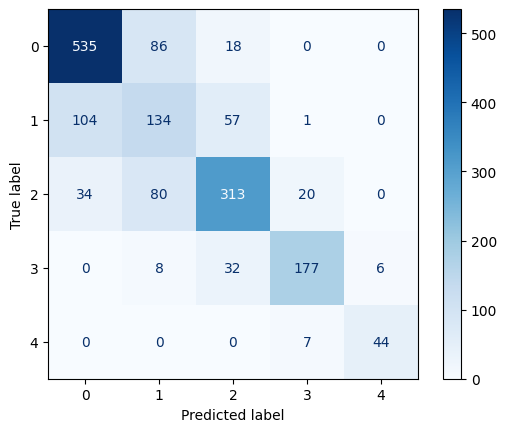

------------------------------------------------------------


In [28]:
search_all(
    SVC,
    {
        'C': [1, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    },
    filtered_dict, 4
)

Report for columns from RFE + Logistic Regression
Best params: {'class_weight': None, 'max_depth': 27, 'n_estimators': 50}
Train accuracy: 99.98%
Test accuracy: 72.28%
              precision    recall  f1-score   support

           0     0.7994    0.8419    0.8201       639
           1     0.4158    0.4257    0.4207       296
           2     0.7367    0.7136    0.7250       447
           3     0.8731    0.7713    0.8190       223
           4     0.8400    0.8235    0.8317        51

    accuracy                         0.7228      1656
   macro avg     0.7330    0.7152    0.7233      1656
weighted avg     0.7251    0.7228    0.7233      1656



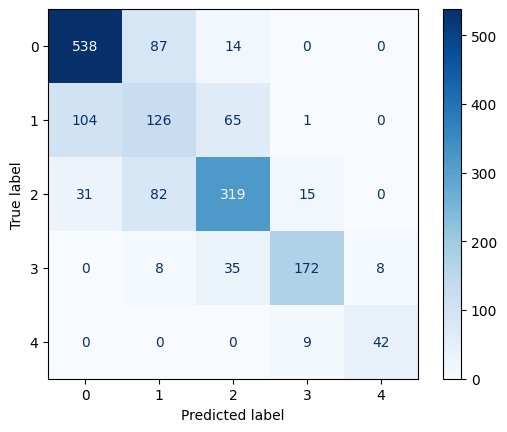

------------------------------------------------------------
Report for columns from RFE + SVC
Best params: {'class_weight': None, 'max_depth': 13, 'n_estimators': 100}
Train accuracy: 98.39%
Test accuracy: 73.07%
              precision    recall  f1-score   support

           0     0.8057    0.8435    0.8242       639
           1     0.4300    0.4459    0.4378       296
           2     0.7459    0.7159    0.7306       447
           3     0.8756    0.7892    0.8302       223
           4     0.8600    0.8431    0.8515        51

    accuracy                         0.7307      1656
   macro avg     0.7434    0.7275    0.7348      1656
weighted avg     0.7335    0.7307    0.7315      1656



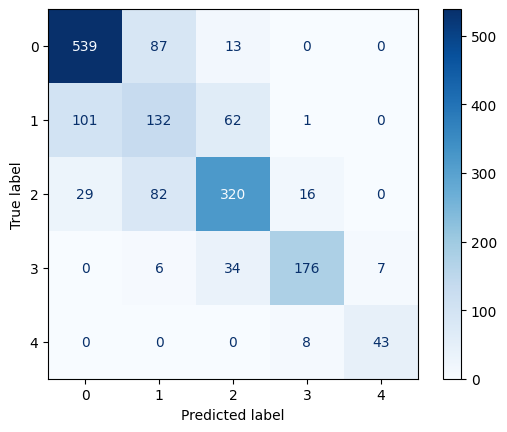

------------------------------------------------------------
Report for columns from Pearson
Best params: {'class_weight': None, 'max_depth': 23, 'n_estimators': 100}
Train accuracy: 100.00%
Test accuracy: 72.71%
              precision    recall  f1-score   support

           0     0.8067    0.8294    0.8179       639
           1     0.4164    0.4459    0.4307       296
           2     0.7512    0.7226    0.7366       447
           3     0.8750    0.7848    0.8274       223
           4     0.8462    0.8627    0.8544        51

    accuracy                         0.7271      1656
   macro avg     0.7391    0.7291    0.7334      1656
weighted avg     0.7324    0.7271    0.7291      1656



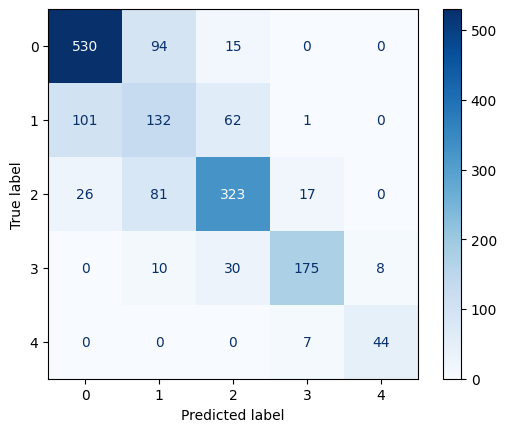

------------------------------------------------------------
Report for columns from Ridge
Best params: {'class_weight': None, 'max_depth': 7, 'n_estimators': 100}
Train accuracy: 87.00%
Test accuracy: 73.43%
              precision    recall  f1-score   support

           0     0.8145    0.8451    0.8295       639
           1     0.4513    0.4696    0.4603       296
           2     0.7391    0.7226    0.7308       447
           3     0.8650    0.7758    0.8180       223
           4     0.8542    0.8039    0.8283        51

    accuracy                         0.7343      1656
   macro avg     0.7448    0.7234    0.7334      1656
weighted avg     0.7372    0.7343    0.7353      1656



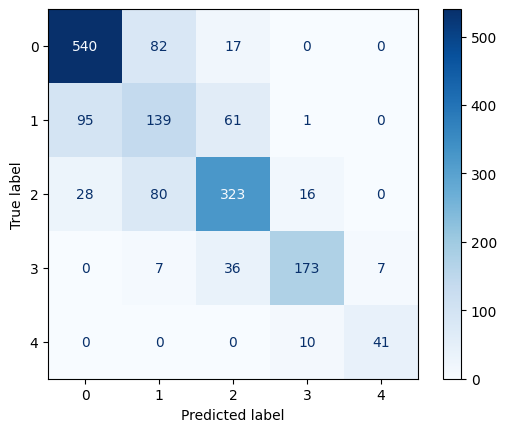

------------------------------------------------------------
Report for columns from Lasso
Best params: {'class_weight': None, 'max_depth': 7, 'n_estimators': 100}
Train accuracy: 87.05%
Test accuracy: 73.43%
              precision    recall  f1-score   support

           0     0.8051    0.8466    0.8253       639
           1     0.4441    0.4561    0.4500       296
           2     0.7494    0.7226    0.7358       447
           3     0.8706    0.7848    0.8255       223
           4     0.8750    0.8235    0.8485        51

    accuracy                         0.7343      1656
   macro avg     0.7488    0.7267    0.7370      1656
weighted avg     0.7365    0.7343    0.7348      1656



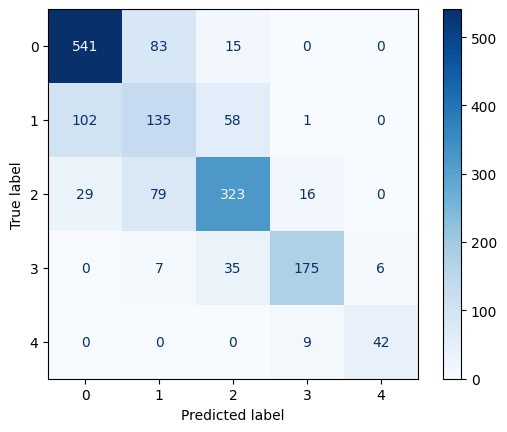

------------------------------------------------------------
Report for columns from Combined
Best params: {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 50}
Train accuracy: 98.68%
Test accuracy: 72.64%
              precision    recall  f1-score   support

           0     0.8015    0.8279    0.8145       639
           1     0.4272    0.4358    0.4314       296
           2     0.7348    0.7315    0.7332       447
           3     0.8788    0.7803    0.8266       223
           4     0.8627    0.8627    0.8627        51

    accuracy                         0.7264      1656
   macro avg     0.7410    0.7276    0.7337      1656
weighted avg     0.7289    0.7264    0.7272      1656



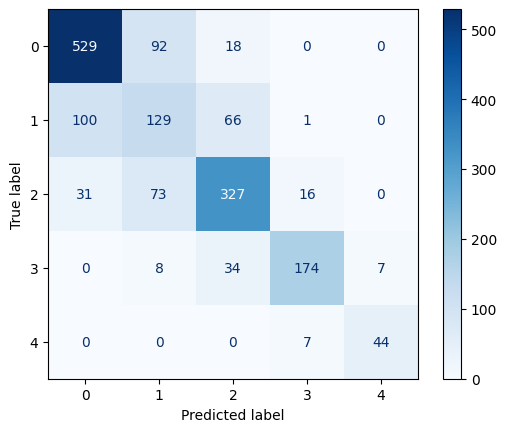

------------------------------------------------------------
Report for columns from All
Best params: {'class_weight': 'balanced', 'max_depth': 17, 'n_estimators': 100}
Train accuracy: 99.69%
Test accuracy: 72.40%
              precision    recall  f1-score   support

           0     0.8054    0.8357    0.8203       639
           1     0.4267    0.4324    0.4295       296
           2     0.7269    0.7204    0.7236       447
           3     0.8607    0.7758    0.8160       223
           4     0.8571    0.8235    0.8400        51

    accuracy                         0.7240      1656
   macro avg     0.7354    0.7176    0.7259      1656
weighted avg     0.7256    0.7240    0.7244      1656



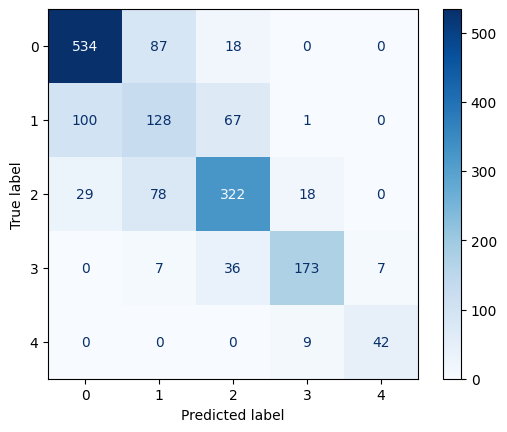

------------------------------------------------------------


In [29]:
search_all(
    RandomForestClassifier,
    {
        'max_depth': list(range(1, 30, 2)),
        'class_weight': ['balanced', None],
        'n_estimators': [20, 50, 100]
    },
    filtered_dict
)

Report for columns from RFE + Logistic Regression
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
Train accuracy: 90.53%
Test accuracy: 73.49%
              precision    recall  f1-score   support

           0     0.8029    0.8607    0.8308       639
           1     0.4331    0.4155    0.4241       296
           2     0.7442    0.7226    0.7333       447
           3     0.8762    0.7937    0.8329       223
           4     0.8627    0.8627    0.8627        51

    accuracy                         0.7349      1656
   macro avg     0.7438    0.7311    0.7368      1656
weighted avg     0.7327    0.7349    0.7331      1656



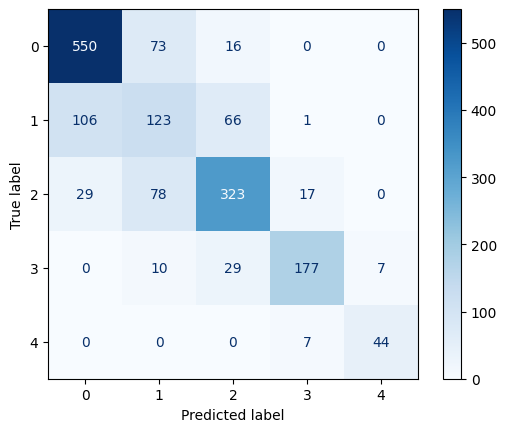

------------------------------------------------------------
Report for columns from RFE + SVC
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Train accuracy: 85.43%
Test accuracy: 73.79%
              precision    recall  f1-score   support

           0     0.7883    0.8623    0.8236       639
           1     0.4509    0.4189    0.4343       296
           2     0.7581    0.7293    0.7434       447
           3     0.8889    0.7892    0.8361       223
           4     0.8333    0.8824    0.8571        51

    accuracy                         0.7379      1656
   macro avg     0.7439    0.7364    0.7389      1656
weighted avg     0.7348    0.7379    0.7351      1656



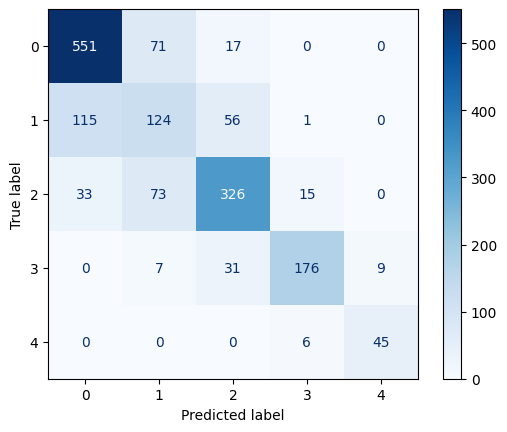

------------------------------------------------------------
Report for columns from Pearson
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Train accuracy: 84.27%
Test accuracy: 72.83%
              precision    recall  f1-score   support

           0     0.8160    0.8122    0.8141       639
           1     0.4202    0.4628    0.4405       296
           2     0.7443    0.7360    0.7402       447
           3     0.8806    0.7937    0.8349       223
           4     0.8627    0.8627    0.8627        51

    accuracy                         0.7283      1656
   macro avg     0.7448    0.7335    0.7385      1656
weighted avg     0.7361    0.7283    0.7317      1656



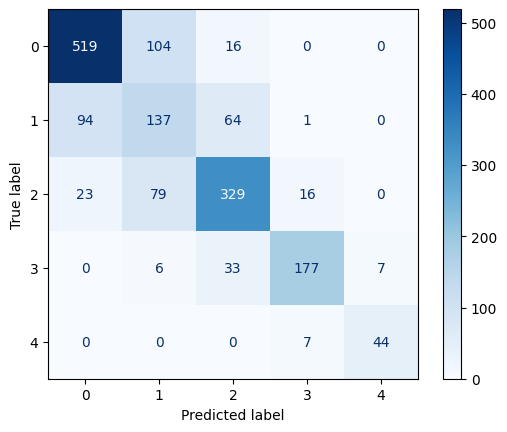

------------------------------------------------------------
Report for columns from Ridge
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Train accuracy: 84.25%
Test accuracy: 73.43%
              precision    recall  f1-score   support

           0     0.7756    0.8764    0.8229       639
           1     0.4413    0.3682    0.4015       296
           2     0.7506    0.7271    0.7386       447
           3     0.8719    0.7937    0.8310       223
           4     0.8824    0.8824    0.8824        51

    accuracy                         0.7343      1656
   macro avg     0.7444    0.7296    0.7353      1656
weighted avg     0.7254    0.7343    0.7278      1656



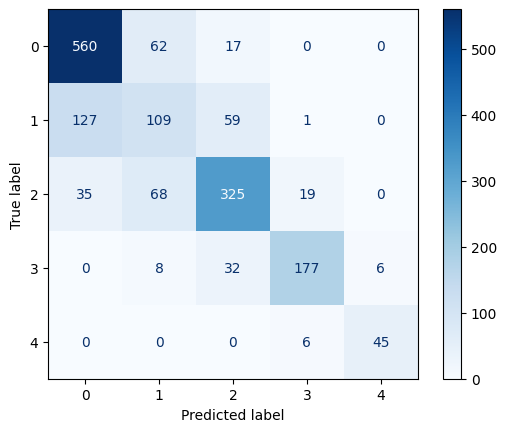

------------------------------------------------------------
Report for columns from Lasso
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Train accuracy: 87.50%
Test accuracy: 73.13%
              precision    recall  f1-score   support

           0     0.7888    0.8592    0.8225       639
           1     0.4359    0.4020    0.4183       296
           2     0.7483    0.7248    0.7364       447
           3     0.8663    0.7848    0.8235       223
           4     0.8462    0.8627    0.8544        51

    accuracy                         0.7313      1656
   macro avg     0.7371    0.7267    0.7310      1656
weighted avg     0.7270    0.7313    0.7281      1656



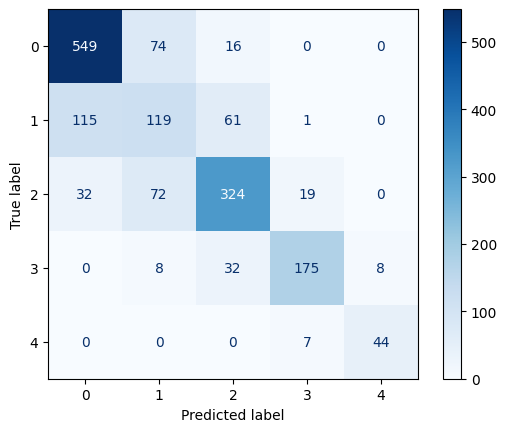

------------------------------------------------------------
Report for columns from Combined
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Train accuracy: 87.63%
Test accuracy: 73.25%
              precision    recall  f1-score   support

           0     0.7812    0.8607    0.8191       639
           1     0.4363    0.3818    0.4072       296
           2     0.7569    0.7383    0.7475       447
           3     0.8592    0.7937    0.8252       223
           4     0.8431    0.8431    0.8431        51

    accuracy                         0.7325      1656
   macro avg     0.7354    0.7235    0.7284      1656
weighted avg     0.7254    0.7325    0.7277      1656



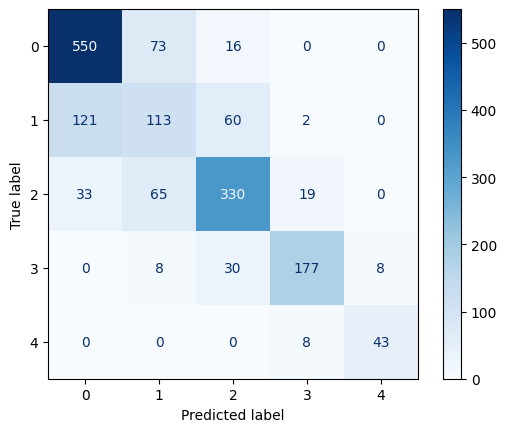

------------------------------------------------------------
Report for columns from All
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Train accuracy: 88.46%
Test accuracy: 73.25%
              precision    recall  f1-score   support

           0     0.7910    0.8529    0.8208       639
           1     0.4281    0.4020    0.4146       296
           2     0.7523    0.7338    0.7429       447
           3     0.8806    0.7937    0.8349       223
           4     0.8462    0.8627    0.8544        51

    accuracy                         0.7325      1656
   macro avg     0.7396    0.7290    0.7335      1656
weighted avg     0.7294    0.7325    0.7301      1656



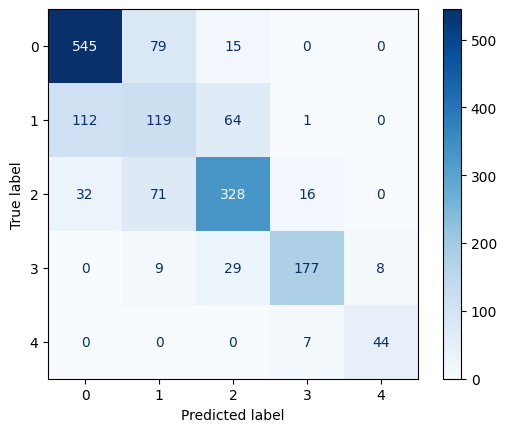

------------------------------------------------------------


In [30]:
search_all(
    XGBClassifier,
    {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    filtered_dict,
)

Report for columns from RFE + Logistic Regression
Best params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Train accuracy: 84.65%
Test accuracy: 71.62%
              precision    recall  f1-score   support

           0     0.7858    0.8498    0.8165       639
           1     0.3910    0.3818    0.3863       296
           2     0.7341    0.6980    0.7156       447
           3     0.8737    0.7758    0.8219       223
           4     0.8491    0.8824    0.8654        51

    accuracy                         0.7162      1656
   macro avg     0.7267    0.7175    0.7211      1656
weighted avg     0.7151    0.7162    0.7146      1656



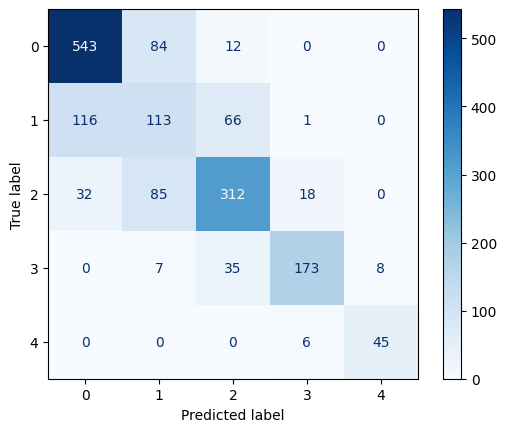

------------------------------------------------------------
Report for columns from RFE + SVC
Best params: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Train accuracy: 84.87%
Test accuracy: 71.32%
              precision    recall  f1-score   support

           0     0.7896    0.8279    0.8083       639
           1     0.3859    0.4054    0.3954       296
           2     0.7393    0.6980    0.7181       447
           3     0.8750    0.7848    0.8274       223
           4     0.8491    0.8824    0.8654        51

    accuracy                         0.7132      1656
   macro avg     0.7278    0.7197    0.7229      1656
weighted avg     0.7172    0.7132    0.7145      1656



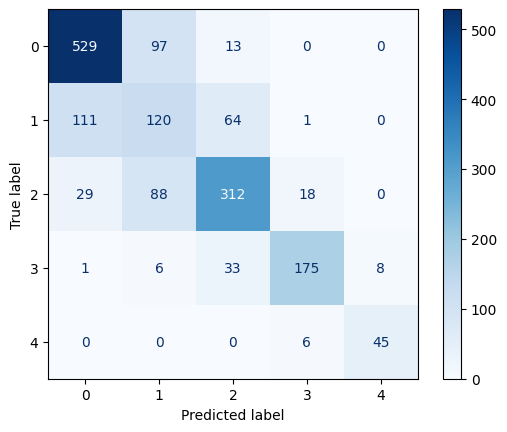

------------------------------------------------------------
Report for columns from Pearson
Best params: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Train accuracy: 82.90%
Test accuracy: 70.59%
              precision    recall  f1-score   support

           0     0.7811    0.8263    0.8030       639
           1     0.3616    0.3750    0.3682       296
           2     0.7405    0.6957    0.7174       447
           3     0.8750    0.7848    0.8274       223
           4     0.8302    0.8627    0.8462        51

    accuracy                         0.7059      1656
   macro avg     0.7177    0.7089    0.7124      1656
weighted avg     0.7093    0.7059    0.7068      1656



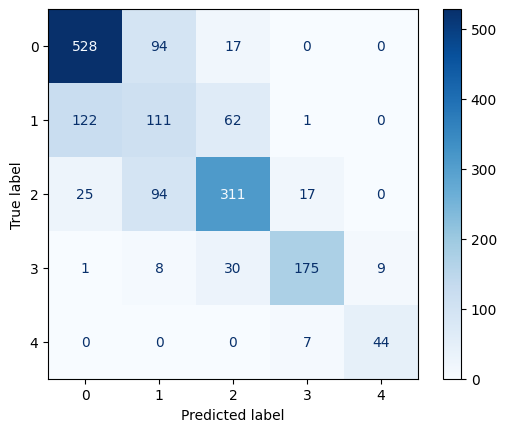

------------------------------------------------------------
Report for columns from Ridge
Best params: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Train accuracy: 100.00%
Test accuracy: 71.50%
              precision    recall  f1-score   support

           0     0.7917    0.8326    0.8116       639
           1     0.4021    0.3953    0.3986       296
           2     0.7198    0.7069    0.7133       447
           3     0.8663    0.7848    0.8235       223
           4     0.8462    0.8627    0.8544        51

    accuracy                         0.7150      1656
   macro avg     0.7252    0.7165    0.7203      1656
weighted avg     0.7144    0.7150    0.7142      1656



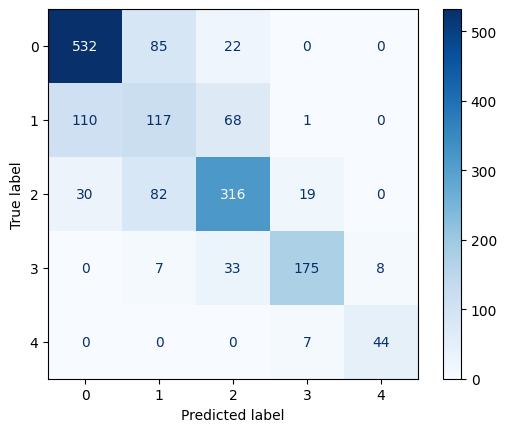

------------------------------------------------------------
Report for columns from Lasso
Best params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Train accuracy: 100.00%
Test accuracy: 70.11%
              precision    recall  f1-score   support

           0     0.7619    0.8764    0.8151       639
           1     0.3686    0.3176    0.3412       296
           2     0.7209    0.6644    0.6915       447
           3     0.8246    0.7803    0.8018       223
           4     0.8372    0.7059    0.7660        51

    accuracy                         0.7011      1656
   macro avg     0.7027    0.6689    0.6831      1656
weighted avg     0.6913    0.7011    0.6937      1656



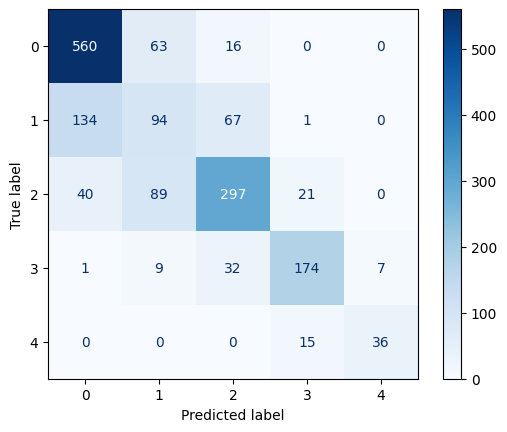

------------------------------------------------------------
Report for columns from Combined
Best params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Train accuracy: 100.00%
Test accuracy: 71.86%
              precision    recall  f1-score   support

           0     0.8036    0.8326    0.8178       639
           1     0.3981    0.4155    0.4066       296
           2     0.7327    0.7114    0.7219       447
           3     0.8737    0.7758    0.8219       223
           4     0.8302    0.8627    0.8462        51

    accuracy                         0.7186      1656
   macro avg     0.7277    0.7196    0.7229      1656
weighted avg     0.7223    0.7186    0.7198      1656



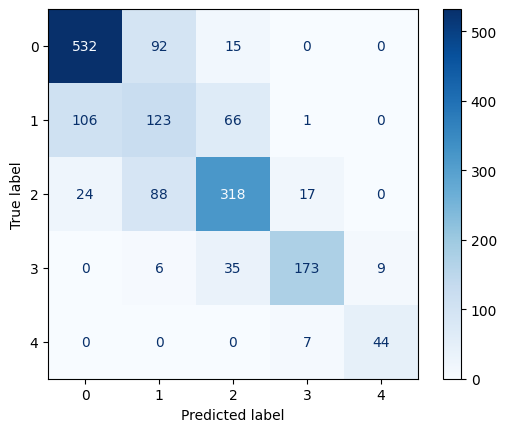

------------------------------------------------------------
Report for columns from All
Best params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Train accuracy: 100.00%
Test accuracy: 68.90%
              precision    recall  f1-score   support

           0     0.7363    0.8826    0.8028       639
           1     0.3471    0.2838    0.3123       296
           2     0.7132    0.6286    0.6683       447
           3     0.8269    0.7713    0.7981       223
           4     0.8696    0.7843    0.8247        51

    accuracy                         0.6890      1656
   macro avg     0.6986    0.6701    0.6813      1656
weighted avg     0.6768    0.6890    0.6789      1656



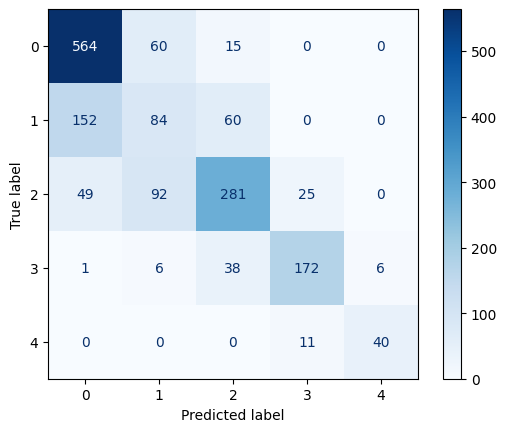

------------------------------------------------------------


In [31]:
def search_all_knn(estimator, param_dict, filtered_dict, n_splits=3):
  for key, val in filtered_dict.items():
    print("Report for columns from", key)
    best_params = custom_grid_search(estimator(),
    param_dict, val)
    print("Best params:", best_params)
    report(estimator(**best_params), val)
    print('-'*60)

search_all_knn(
    KNeighborsClassifier,
    {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    filtered_dict,
)

In [32]:
# def search_all_no_state(estimator, param_dict, filtered_dict, n_splits=3):
#   for key, val in filtered_dict.items():
#     print("Report for columns from", key)
#     best_params = custom_grid_search(estimator(),
#     param_dict, val)
#     print("Best params:", best_params)
#     report(estimator(**best_params), val)
#     print('-'*60)

In [33]:
# svc_best = SVC(random_state=1024, C=1000, gamma=0.01, kernel='rbf',probability=True)
# svc_best.fit(X_train[filtered_dict["RFE + Logistic Regression"]], y_train_np)
# y_pred = svc_best.predict(X_test[filtered_dict["RFE + Logistic Regression"]].to_numpy())
# print(classification_report(y_test_np, y_pred, digits=4))

In [34]:
# xgboost_best = XGBClassifier(random_state=1024,colsample_bytree=1.0,learning_rate=0.1,max_depth=4,n_estimators=50, subsample=0.8)
# xgboost_best.fit(X_train[filtered_dict["RFE + SVC"]], y_train_np)
# y_pred = xgboost_best.predict(X_test[filtered_dict["RFE + SVC"]].to_numpy())
# print(classification_report(y_test_np, y_pred, digits=4))

In [35]:
# cm = confusion_matrix(y_test_np, y_pred, labels=svc_best.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_best.classes_)
# disp.plot(cmap='Blues')
# plt.show()

In [36]:
# from sklearn.inspection import permutation_importance
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

# perm_importance = permutation_importance(xgboost_best, X_test[filtered_dict["RFE + SVC"]], y_test_np)
# features = np.array(filtered_dict["RFE + SVC"])

In [37]:
# import pandas as pd

# perm_importances = pd.Series(perm_importance.importances_mean, index=features)
# perm_importances[perm_importances < 0] = 0
# perm_importances.sort_values(ascending=True, inplace=True)

# plt.figure(figsize=(16,10))
# perm_importances.plot(kind='barh')
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.tight_layout()
# plt.show()

# test LIME

In [38]:
# !pip install lime

In [39]:
# import lime
# import lime.lime_tabular

In [40]:
# explainer = lime.lime_tabular.LimeTabularExplainer(
#     X_train[filtered_dict["RFE + Logistic Regression"]].to_numpy(),
#     feature_names=filtered_dict["RFE + Logistic Regression"],
#     class_names=[str(c) for c in sorted(np.unique(y_train_np))],
#     mode='classification'
# )

In [41]:
# i = 104
# sample = X_test[filtered_dict["RFE + Logistic Regression"]].iloc[i].to_numpy().reshape(1, -1)

In [42]:
# print("actualy class: ", y_test_np[i])
# print("predicted class: ", svc_best.predict(sample)[0])
# print("predicted proba: ", svc_best.predict_proba(sample)[0])

# exp_svc = explainer.explain_instance(sample[0], svc_best.predict_proba, num_features=10)
# exp_svc.show_in_notebook(show_table=True, show_all=False)